In [310]:
import jax
import cvxpy as cp
import numpy as np
import jax.numpy as jnp
import polytope as pt

%matplotlib inline
import matplotlib.pyplot as plt

## Set parameters

In [311]:
num_constraints = 8
dim = 2 # size of variable U

# Lower bound of U
lb = jnp.array([-2,-2]).reshape(-1,1)
# Upper bound of U
ub = jnp.array([2, 2]).reshape(-1,1)

# for jax random number generator
key = jax.random.PRNGKey(10)
np.random.seed(20)

# number of monte carlo samples for computing volume
num_samples=50000

### Set hard constraint (cannot be removed): size 2 * dim

In [312]:
A_bound = np.array([[1, 0], [-1, 0], [0, 1], [0, -1]]) # for defining absolute hard constraints. cannot be removed
b_bound = np.array([2.5,2.5,2.5,2.5]).reshape(-1,1)

### Randomly contruct constraints (num_constraints - 2 * dim)

In [313]:
# randomly construct constraint
A = -1 + 2 * np.random.rand(num_constraints-2*dim, dim)
b = -1 + 2 * np.random.rand(num_constraints-2*dim,1)
A = np.append(A, A_bound, axis=0)
b = np.append(b, b_bound, axis=0)

### Cvxpy LP solver just to see if solution exists or not

In [314]:
# define LP problem
A_cp = cp.Parameter((num_constraints, dim), value = np.zeros((num_constraints, dim)))
b_cp = cp.Parameter((num_constraints, 1), value=np.ones((num_constraints, 1)))
x_cp = cp.Variable((dim,1))
const = [A_cp @ x_cp <= b_cp]
obj = cp.Minimize( cp.sum(x_cp) )
prob = cp.Problem( obj, const )

In [315]:
# Solve LP

A_cp.value = A
b_cp.value = b
prob.solve()
print(f"status: {prob.status}")
print(f"sol: {x_cp.value}")

status: optimal
sol: [[-0.54235]
 [-2.5    ]]


In [316]:
# @jax.jit
def mc_polytope_volume(subkey, A, b, lb = -1, ub = 1):
    Anorm = jnp.linalg.norm(A, axis=1)
    A = A / Anorm.reshape(-1,1)
    b = b / Anorm.reshape(-1,1)
    samples = jax.random.uniform( subkey, shape=(dim,num_samples), minval=lb, maxval=ub )     
    aux = A @ samples - b
    aux = jnp.nonzero(jnp.all(aux < 0, 0))[0].shape[0]
    total_volume = jnp.prod(ub - lb, axis=0)
    vol = total_volume * aux / num_samples
    return vol

def plot_polytope_lines(ax, hull, u_bound=3):
    xs = np.linspace( -u_bound, u_bound, 3 )
    A, b = hull.A, hull.b
    alpha = 0.1
    for i in range(A.shape[0]):
        if np.abs(A[i,1])>0.001:
            ax.plot( xs, (b[i] - A[i,0]*xs)/A[i,1], color='k', linestyle='--', alpha = alpha )
        else:
            if np.abs(A[i,0])>0.001:
                ax.axvline( b[i]/A[i,0], color='k', linestyle='--', alpha = alpha )
            else:
                ax.axvline( 0.0, color='k', linestyle='--', alpha = alpha )

In [317]:
hull = pt.Polytope(A, b)
print(f"volume from custom function: {mc_polytope_volume( key, A, b, lb = lb, ub = ub)}")# , num_samples=50000 ))
lb, ub = pt.bounding_box(hull)
print(f"volume from custom function: {mc_polytope_volume( key, A, b, lb = lb, ub = ub)}")# , num_samples=50000 ))
print(f"volume from library: {hull.volume}")

volume from custom function: [0.57216]
volume from custom function: [1.30446]
volume from library: 1.2841099328456413


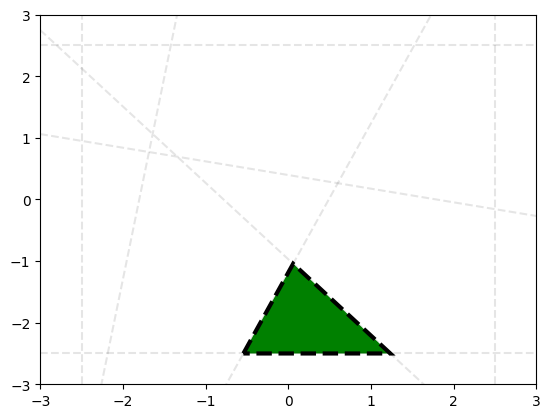

In [318]:
fig, ax  = plt.subplots()
ax.set_xlim([-3, 3])
ax.set_ylim([-3,3])
hull = pt.Polytope( A, b )
hull_plot = hull.plot(ax, color = 'g')
plot_polytope_lines(ax, hull )